In [1]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.transforms as transforms
import matplotlib as mpl
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)
width  = 3.402
height = width / 1.2

import sys
print(sys.version)
sys.path.append('../')
import time

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.learning.blr_slip import SlipBayesianLinearRegression, FullBodySlipBayesianLinearRegression
from models.learning.blr_slip_acceleration import SlipAccelerationBayesianLinearRegression, FullBodySlipAccelerationBayesianLinearRegression
from models.learning.blr_acceleration import AccelerationBayesianLinearRegression, FullBodyAccelerationBayesianLinearRegression
from models.learning.gp_slip import *
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *


from util.transform_algebra import *
from util.util_func import *

from sklearn import linear_model

3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]


In [2]:
# import all slip datasets

train_datasets = []
validate_datasets = []

dataset_paths = [] 
dataset_labels = []
dataset_paths.append('../data/ral2023_dataset/husky/boreal_snow/acceleration_dataset.pkl')
dataset_labels.append(r'Hu_snow')
dataset_paths.append('../data/ral2023_dataset/husky/grand_salon_tile_inflated/acceleration_dataset.pkl')
dataset_labels.append(r'Hu_tile')
# dataset_paths.append('../data/ral2023_dataset/husky/grand_salon_left-deflated/acceleration_dataset.pkl')
# dataset_labels.append('H_tile_ld')
dataset_paths.append('../data/ral2023_dataset/marmotte/boreal_snow/acceleration_dataset.pkl')
dataset_labels.append(r'HD2_snow')
        # dataset_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_a/acceleration_dataset.pkl')
        # dataset_labels.append('M_hard_snow_a')
dataset_paths.append('../data/ral2023_dataset/marmotte/grand_salon_tile_b/acceleration_dataset.pkl')
dataset_labels.append(r'HD2_tile')
# dataset_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_b/acceleration_dataset.pkl')
# dataset_labels.append('M_hard_snow')
# dataset_paths.append('../data/ral2023_dataset/warthog_tracks/boreal_mud/acceleration_dataset.pkl')
# dataset_labels.append(r'Wt_mud')
# dataset_paths.append('../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/acceleration_dataset.pkl')
# dataset_labels.append('Wt_crust')
dataset_paths.append('../data/ral2023_dataset/warthog_wheels/gravel_1/acceleration_dataset.pkl')
dataset_labels.append(r'Ww_gravel')

for dataset_path in dataset_paths:
    full_dataset = pd.read_pickle(dataset_path)
    full_dataset_length = len(full_dataset)
    train_dataset = full_dataset[:int(full_dataset_length/2)]
    train_datasets.append(train_dataset)
    validate_dataset = full_dataset[int(full_dataset_length/2):]
    validate_datasets.append(validate_dataset)
    print(dataset_path)


# print(train_dataset)

../data/ral2023_dataset/husky/boreal_snow/acceleration_dataset.pkl
../data/ral2023_dataset/husky/grand_salon_tile_inflated/acceleration_dataset.pkl
../data/ral2023_dataset/marmotte/boreal_snow/acceleration_dataset.pkl
../data/ral2023_dataset/marmotte/grand_salon_tile_b/acceleration_dataset.pkl
../data/ral2023_dataset/warthog_wheels/gravel_1/acceleration_dataset.pkl


In [3]:
# import powertrain vels

cmd_left_str_list = []
cmd_right_str_list = []
for i in range(0, 40):
    str_cmd_left_i = 'cmd_left_' + str(i)
    str_cmd_right_i = 'cmd_right_' + str(i)
    cmd_left_str_list.append(str_cmd_left_i)
    cmd_right_str_list.append(str_cmd_right_i)
# cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
# cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()

encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
# encoder_left_vels_array = validate_dataset[encoder_left_str_list].to_numpy()
# encoder_right_vels_array = validate_dataset[encoder_right_str_list].to_numpy()

transitory_left_str_list = []
transitory_right_str_list = []
for i in range(0, 40):
    str_transitory_left_i = 'transitory_vel_left_' + str(i)
    str_transitory_right_i = 'transitory_vel_right_' + str(i)
    transitory_left_str_list.append(str_transitory_left_i)
    transitory_right_str_list.append(str_transitory_right_i)
# transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
# transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()

    

In [4]:
# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
# idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
# idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
# idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()

icp_x_str_list = []
icp_y_str_list = []
icp_z_str_list = []
icp_roll_str_list = []
icp_pitch_str_list = []
icp_yaw_str_list = []
for i in range(0, 40):
    str_icp_x_i = 'icp_interpolated_x_' + str(i)
    str_icp_y_i = 'icp_interpolated_y_' + str(i)
    str_icp_yaw_i = 'icp_interpolated_yaw_' + str(i)
    icp_x_str_list.append(str_icp_x_i)
    icp_y_str_list.append(str_icp_y_i)
    icp_yaw_str_list.append(str_icp_yaw_i)
# icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
# icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
# icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()

# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
icp_vel_x_array = validate_dataset[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = validate_dataset[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = validate_dataset[str_icp_vel_yaw_list].to_numpy()

# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
    
# body_vel_disturption_x_array = validate_dataset[str_body_vel_disturption_x_list].to_numpy()
# body_vel_disturption_y_array = validate_dataset[str_body_vel_disturption_y_list].to_numpy()
# body_vel_disturption_yaw_array = validate_dataset[str_body_vel_disturption_yaw_list].to_numpy()

In [5]:
# import models

blr_slip_param_paths = []
blr_slip_param_paths.append('../data/ral2023_dataset/husky/boreal_snow/trained_params/slip/blr/steady-state/')
blr_slip_param_paths.append('../data/ral2023_dataset/husky/grand_salon_tile_inflated/trained_params/slip/blr/steady-state/')
# blr_slip_param_paths.append('../data/ral2023_dataset/husky/grand_salon_left-deflated/trained_params/slip/blr/steady-state/')
blr_slip_param_paths.append('../data/ral2023_dataset/marmotte/boreal_snow/trained_params/slip/blr/steady-state/')
blr_slip_param_paths.append('../data/ral2023_dataset/marmotte/grand_salon_tile_b/trained_params/slip/blr/steady-state/')
#         # blr_slip_param_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_a/trained_params/slip/blr/steady-state/')
# blr_slip_param_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_b/trained_params/slip/blr/steady-state/')
# blr_slip_param_paths.append('../data/ral2023_dataset/warthog_tracks/boreal_mud/trained_params/slip/blr/steady-state/')
# blr_slip_param_paths.append('../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/trained_params/slip/blr/steady-state/')
blr_slip_param_paths.append('../data/ral2023_dataset/warthog_wheels/gravel_1/trained_params/slip/blr/steady-state/')

# gp_slip_param_paths = []
# gp_slip_param_paths.append('../data/ral2023_dataset/husky/boreal_snow/trained_params/slip/gp/steady-state/')
# gp_slip_param_paths.append('../data/ral2023_dataset/husky/grand_salon_tile_inflated/trained_params/slip/gp/steady-state/')
# gp_slip_param_paths.append('../data/ral2023_dataset/husky/grand_salon_left-deflated/trained_params/slip/gp/steady-state/')
# gp_slip_param_paths.append('../data/ral2023_dataset/marmotte/boreal_snow/trained_params/slip/gp/steady-state/')
# gp_slip_param_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_a/trained_params/slip/gp/steady-state/')
# #         # gp_slip_param_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_b/trained_params/slip/gp/steady-state/')
# gp_slip_param_paths.append('../data/ral2023_dataset/marmotte/grand_salon_tile_b/slip_dataset_all.pkl')
# gp_slip_param_paths.append('../data/ral2023_dataset/warthog_tracks/boreal_mud/trained_params/slip/gp/steady-state/')
# gp_slip_param_paths.append('../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/trained_params/slip/gp/steady-state/')
#
# blr_slip_acceleration_param_paths = []
# blr_slip_acceleration_param_paths.append('../data/ral2023_dataset/husky/boreal_snow/trained_params/slip_acceleration/blr/')
# blr_slip_acceleration_param_paths.append('../data/ral2023_dataset/husky/grand_salon_tile_inflated/trained_params/slip_acceleration/blr/')
# blr_slip_acceleration_param_paths.append('../data/ral2023_dataset/husky/grand_salon_left-deflated/trained_params/slip_acceleration/blr/')
# blr_slip_acceleration_param_paths.append('../data/ral2023_dataset/marmotte/boreal_snow/trained_params/slip_acceleration/blr/')
# blr_slip_acceleration_param_paths.append('../data/ral2023_dataset/marmotte/grand_salon_tile_b/trained_params/slip_acceleration/blr/')
# #         # blr_slip_acceleration_param_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_a/trained_params/slip_acceleration/blr/')
# blr_slip_acceleration_param_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_b/trained_params/slip_acceleration/blr/')
# blr_slip_acceleration_param_paths.append('../data/ral2023_dataset/warthog_tracks/boreal_mud/trained_params/slip_acceleration/blr/')
# blr_slip_acceleration_param_paths.append('../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/trained_params/slip_acceleration/blr/')

blr_acceleration_param_paths = []
blr_acceleration_param_paths.append('../data/ral2023_dataset/husky/boreal_snow/trained_params/acceleration/blr/')
blr_acceleration_param_paths.append('../data/ral2023_dataset/husky/grand_salon_tile_inflated/trained_params/acceleration/blr/')
# blr_acceleration_param_paths.append('../data/ral2023_dataset/husky/grand_salon_left-deflated/trained_params/acceleration/blr/')
blr_acceleration_param_paths.append('../data/ral2023_dataset/marmotte/boreal_snow/trained_params/acceleration/blr/')
# blr_acceleration_param_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_a/trained_params/acceleration/blr/')
#         # gp_slip_param_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_b/trained_params/acceleration/blr/')
blr_acceleration_param_paths.append('../data/ral2023_dataset/marmotte/grand_salon_tile_b/trained_params/acceleration/blr/')
# blr_acceleration_param_paths.append('../data/ral2023_dataset/warthog_tracks/boreal_mud/trained_params/acceleration/blr/')
# blr_acceleration_param_paths.append('../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/trained_params/acceleration/blr/')
blr_acceleration_param_paths.append('../data/ral2023_dataset/warthog_wheels/gravel_1/trained_params/acceleration/blr/')

# robot = 'husky'
robot = 'marmotte'
# robot = 'warthog-track'
if robot=='husky':
    wheel_radius = 0.33 / 2
    baseline = 0.55
    dt = 0.05
if robot=='marmotte':
    wheel_radius = 0.116
    baseline = 0.5927
    dt=0.05
if robot == 'warthog':
    wheel_radius = 0.3
    baseline = 1.1652
    dt = 0.05
    
slip_input_dimensions = 2
a_param_init = 0
b_param_init = 0
param_variance_init = 999999999999999999999
variance_init = 1000000000
kappa_param = 1
    
# ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt)
# full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
# full_body_slip_blr.load_params(blr_params_path)

# print(full_body_slip_blr.body_x_slip_blr.weights)

In [6]:
# compute M-RMSE

def compute_single_step_error(meas_state, pred_state):
    pred_error = meas_state - pred_state
    pred_error[2] = wrap2pi(pred_error[2]) # wrap yaw angle error to pi
    translational_error_squared_scalar = pred_error.T @ np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]]) @ pred_error
    rotational_error_squared_scalar = pred_error.T @ np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]) @ pred_error
    return np.sqrt(translational_error_squared_scalar), np.sqrt(rotational_error_squared_scalar)

def horizon_mrsme(meas_states, pred_states):
    n_predictions = meas_states.shape[0]
    prediction_error_sum = 0
    for i in range(0, n_predictions):
        prediction_error_sum += compute_single_step_error(meas_states[i], pred_states[i])
    return np.sqrt(prediction_error_sum / n_predictions)

window_size = 40

def compute_prediction_metrics(validate_dataset, robot, blr_param_path, blr_acceleration_param_path):
    n_test_windows = len(validate_dataset)
    
    cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
    cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()
    transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
    transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()
    idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
    idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
    idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()
    icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
    icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
    icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()
    icp_vel_x_array = validate_dataset[str_icp_vel_x_list].to_numpy()
    icp_vel_y_array = validate_dataset[str_icp_vel_y_list].to_numpy()
    icp_vel_yaw_array = validate_dataset[str_icp_vel_yaw_list].to_numpy()
    body_vel_disturption_x_array = validate_dataset[str_body_vel_disturption_x_list].to_numpy()
    body_vel_disturption_y_array = validate_dataset[str_body_vel_disturption_y_list].to_numpy()
    body_vel_disturption_yaw_array = validate_dataset[str_body_vel_disturption_yaw_list].to_numpy()
    steady_state_mask_array = validate_dataset['steady_state_mask'].to_numpy() == 1.0

    # TODO : Try only in steady-state or transitory-state windows to check if models perform better in some cases

    if robot=='Hu':
        wheel_radius = 0.33 / 2
        baseline = 0.55
        dt = 0.05
    if robot=='HD2':
        wheel_radius = 0.116
        baseline = 0.5927
        dt=0.05
    if robot == 'Wt':
        wheel_radius = 0.3
        baseline = 1.1652
        dt = 0.05
    if robot == 'Ww':
        wheel_radius = 0.3
        baseline = 1.08
        dt = 0.05
        
    slip_input_dimensions = 2
    a_param_init = 0
    b_param_init = 0
    param_variance_init = 999999999999999999999
    variance_init = 1000000000
    kappa_param = 1
    
    ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt)
    full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    full_body_slip_blr.load_params(blr_param_path)

    # full_body_slip_acceleration_blr = FullBodySlipAccelerationBayesianLinearRegression(2, 1, 4, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    # full_body_slip_acceleration_blr.load_params(blr_slip_acceleration_param_path)
    
    length_scales_x = [0.1]
    length_scales_y = [0.1]
    length_scales_yaw = [100]
    noise_levels_x = 0.1
    noise_levels_y = 0.1
    noise_levels_yaw = 0.5
    n_restarts_optimizer = 20
    
    # full_body_slip_gp = FullBodySlipGaussianProcess(1, 1, 3, length_scales_x, length_scales_y, length_scales_yaw,
    #              noise_levels_x, noise_levels_y, noise_levels_yaw, n_restarts_optimizer, baseline, wheel_radius, dt, kappa_param)
    # full_body_slip_gp.load_params(gp_param_path)

    full_body_acceleration_blr = FullBodyAccelerationBayesianLinearRegression(2, 2, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    full_body_acceleration_blr.load_params(blr_acceleration_param_path)
    
    blr_predictions = np.zeros((n_test_windows, window_size, 3))
    gp_predictions = np.zeros((n_test_windows, window_size, 3))
    idd_predictions = np.zeros((n_test_windows, window_size, 3))
    cmd_input_horizon = np.zeros((2, window_size))
    transitory_input_horizon = np.zeros((2, window_size))
    cmd_body_vel_horizon = np.zeros((2, window_size))
    transitory_body_vel_horizon = np.zeros((3, window_size))
    blr_slip_body_vel_horizon = np.zeros((3, window_size))
    gp_slip_body_vel_horizon = np.zeros((3, window_size))

    cmd_idd_horizon_prediction = np.zeros((3, window_size))
    transitory_idd_horizon_prediction = np.zeros((3, window_size))
    blr_slip_horizon_prediction = np.zeros((3, window_size))
    gp_slip_horizon_prediction = np.zeros((3, window_size))
    blr_slip_acceleration_horizon_prediction = np.zeros((3, window_size))
    acceleration_horizon_prediction = np.zeros((3, window_size))
    acceleration_blr_horizon_prediction = np.zeros((3, window_size))
    icp_horizon_meas = np.zeros((3, window_size))
    icp_vel_meas = np.zeros((3, window_size))

    cmd_idd_prediction_errors_translational = np.zeros(n_test_windows)
    cmd_idd_prediction_errors_rotational = np.zeros(n_test_windows)
    transitory_idd_prediction_errors_translational = np.zeros(n_test_windows)
    transitory_idd_prediction_errors_rotational = np.zeros(n_test_windows)
    blr_slip_prediction_errors_translational = np.zeros(n_test_windows)
    blr_slip_prediction_errors_rotational = np.zeros(n_test_windows)
    gp_slip_prediction_errors = np.zeros(n_test_windows)
    blr_slip_acceleration_prediction_errors_translational = np.zeros(n_test_windows)
    blr_slip_acceleration_prediction_errors_rotational = np.zeros(n_test_windows)
    blr_acceleration_prediction_errors_translational = np.zeros(n_test_windows)
    blr_acceleration_prediction_errors_rotational = np.zeros(n_test_windows)
    idd_body_vels_array = np.zeros((window_size, 3))
    blr_init_state_covariance = np.eye(3) * 0.1
    gp_init_state_covariance = np.eye(3) * 0.1
    acceleration_blr_init_state_covariance = np.eye(3) * 0.1
    acceleration_blr_init_vel_covariance = np.eye(3) * 0.1

    for j in range(0, n_test_windows):
        # if not steady_state_mask_array[j]:
        #     continue
        cmd_input_horizon[0, :] = cmd_left_vels_array[j, :]
        cmd_input_horizon[1, :] = cmd_right_vels_array[j, :]

        transitory_input_horizon[0, :] = transitory_left_vels_array[j, :]
        transitory_input_horizon[1, :] = transitory_right_vels_array[j, :]

        transitory_body_vel_horizon[0, :] = idd_body_vel_x_array[j, :]
        transitory_body_vel_horizon[1, :] = idd_body_vel_y_array[j, :]
        transitory_body_vel_horizon[2, :] = idd_body_vel_yaw_array[j, :]

        cmd_idd_horizon_prediction_error_translational = 0
        cmd_idd_horizon_prediction_error_rotational = 0
        transitory_idd_horizon_prediction_error_translational = 0
        transitory_idd_horizon_prediction_error_rotational = 0
        blr_horizon_prediction_error_translational = 0
        blr_horizon_prediction_error_rotational = 0
        gp_horizon_prediction_error = 0
        blr_slip_acceleration_horizon_prediction_error = 0
        blr_acceleration_horizon_prediction_error_translational = 0
        blr_acceleration_horizon_prediction_error_rotational = 0

        for i in range(0, window_size-1):
            icp_2d_state = np.array([icp_x_array[j, i], icp_y_array[j, i], icp_yaw_array[j, i]])

            cmd_idd_horizon_prediction[:, i+1] = ideal_diff_drive.predict_2d(cmd_idd_horizon_prediction[:, i], cmd_input_horizon[:, i])
            cmd_idd_horizon_prediction_error_translational_step, cmd_idd_horizon_prediction_error_rotational_step = compute_single_step_error(icp_2d_state, cmd_idd_horizon_prediction[:, i])
            cmd_idd_horizon_prediction_error_translational += cmd_idd_horizon_prediction_error_translational_step
            cmd_idd_horizon_prediction_error_rotational += cmd_idd_horizon_prediction_error_rotational_step

            transitory_idd_horizon_prediction[:, i+1] = ideal_diff_drive.predict_2d(transitory_idd_horizon_prediction[:, i], transitory_input_horizon[:, i])
            transitory_idd_horizon_prediction_error_translational_step, transitory_idd_horizon_prediction_error_rotational_step = compute_single_step_error(icp_2d_state, transitory_idd_horizon_prediction[:, i])
            transitory_idd_horizon_prediction_error_translational += transitory_idd_horizon_prediction_error_translational_step
            transitory_idd_horizon_prediction_error_rotational += transitory_idd_horizon_prediction_error_rotational_step

        idd_body_vels_array[:, 0] = idd_body_vel_x_array[j, :]
        idd_body_vels_array[:, 1] = idd_body_vel_y_array[j, :]
        idd_body_vels_array[:, 2] = idd_body_vel_yaw_array[j, :]

        icp_vel_meas[0, :] = icp_vel_x_array[j, :]
        icp_vel_meas[1, :] = icp_vel_y_array[j, :]
        icp_vel_meas[2, :] = icp_vel_yaw_array[j, :]

        prediction_means_blr, prediction_covariances_blr = full_body_slip_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array, 
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)
        # prediction_means_gp, prediction_covariances_gp = full_body_slip_gp.predict_horizon_from_body_idd_vels(idd_body_vels_array,
        #                                                                                                 gp_slip_horizon_prediction[:, 0], gp_init_state_covariance)
        #
        # prediction_means_blr_slip_acceleration, prediction_covariances_blr_slip_acceleration = full_body_slip_acceleration_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array,
        #                                                                                                 blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)

        prediction_means_acceleration_blr, prediction_covariances_acceleration_blr = full_body_acceleration_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array,
                                                                                                        acceleration_horizon_prediction[:, 0], acceleration_blr_init_state_covariance,
                                                                                                        icp_vel_meas[:, 0],
                                                                                                        acceleration_blr_init_vel_covariance)

        icp_horizon_meas[0, :] = icp_x_array[j, :]
        icp_horizon_meas[1, :] = icp_y_array[j, :]
        icp_horizon_meas[2, :] = icp_yaw_array[j, :]

        for i in range(0, window_size):
            icp_2d_state = np.array([icp_x_array[j, i], icp_y_array[j, i], icp_yaw_array[j, i]])
            blr_horizon_prediction_error_translational_step, blr_horizon_prediction_error_rotational_step = compute_single_step_error(icp_2d_state, prediction_means_blr[:, i])
            blr_horizon_prediction_error_translational += blr_horizon_prediction_error_translational_step
            blr_horizon_prediction_error_rotational += blr_horizon_prediction_error_rotational_step
            # gp_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means_gp[:, i])
            # blr_slip_acceleration_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means_blr_slip_acceleration[:, i])
            blr_acceleration_horizon_prediction_error_translational_step, blr_acceleration_horizon_prediction_error_rotational_step = compute_single_step_error(icp_2d_state, prediction_means_acceleration_blr[:, i])
            blr_acceleration_horizon_prediction_error_translational += blr_acceleration_horizon_prediction_error_translational_step
            blr_acceleration_horizon_prediction_error_rotational += blr_acceleration_horizon_prediction_error_rotational_step

        # blr_msre = np.diag(blr_prediction_errors @ blr_prediction_errors.T)
        # blr_slip_prediction_errors_translational[j] = np.sqrt(np.sqrt((blr_msre.T @ blr_msre) / window_size))

        # print('blr : ', prediction_means_blr[2, -1])
        # print('icp : ', icp_horizon_meas[2, -1])


        cmd_idd_prediction_errors_translational[j] = cmd_idd_horizon_prediction_error_translational / window_size
        cmd_idd_prediction_errors_rotational[j] = cmd_idd_horizon_prediction_error_rotational / window_size
        transitory_idd_prediction_errors_translational[j] = transitory_idd_horizon_prediction_error_translational / window_size
        transitory_idd_prediction_errors_rotational[j] = transitory_idd_horizon_prediction_error_rotational / window_size
        blr_slip_prediction_errors_translational[j] = blr_horizon_prediction_error_translational / window_size
        blr_slip_prediction_errors_rotational[j] = blr_horizon_prediction_error_rotational / window_size
        # gp_slip_prediction_errors[j] = gp_horizon_prediction_error / window_size
        blr_acceleration_prediction_errors_translational[j] = blr_acceleration_horizon_prediction_error_translational / window_size
        blr_acceleration_prediction_errors_rotational[j] = blr_acceleration_horizon_prediction_error_rotational / window_size
        # blr_slip_acceleration_prediction_errors[j] = blr_slip_acceleration_horizon_prediction_error / window_size

    # cmd_idd_prediction_errors = cmd_idd_prediction_errors[steady_state_mask_array]
    # transitory_idd_prediction_errors = transitory_idd_prediction_errors[steady_state_mask_array]
    # blr_slip_prediction_errors = blr_slip_prediction_errors[steady_state_mask_array]
    # gp_slip_prediction_errors = gp_slip_prediction_errors[steady_state_mask_array]
    # blr_acceleration_prediction_errors = blr_acceleration_prediction_errors[steady_state_mask_array]
    # blr_slip_acceleration_prediction_errors = blr_slip_acceleration_prediction_errors[steady_state_mask_array]

    return cmd_idd_prediction_errors_translational, cmd_idd_prediction_errors_rotational, transitory_idd_prediction_errors_translational, transitory_idd_prediction_errors_rotational, blr_slip_prediction_errors_translational, blr_slip_prediction_errors_rotational, blr_acceleration_prediction_errors_translational, blr_acceleration_prediction_errors_rotational
    
cmd_idd_prediction_errors_list_translational = []
cmd_idd_prediction_errors_list_rotational = []
transitory_idd_prediction_errors_list_translational = []
transitory_idd_prediction_errors_list_rotational = []
blr_slip_prediction_errors_list_translational = []
blr_slip_prediction_errors_list_rotational = []
# gp_slip_prediction_errors_list = []
# blr_slip_acceleration_prediction_errors_list = []
blr_acceleration_prediction_errors_list_translational = []
blr_acceleration_prediction_errors_list_rotational = []
for i in range(len(validate_datasets)):
    print(dataset_paths[i])
    validate_dataset = validate_datasets[i]
    dataset_label = dataset_labels[i]
    robot = dataset_label.split('_')[0]
    blr_slip_param_path = blr_slip_param_paths[i]
    # gp_param_path = gp_slip_param_paths[i]
    # blr_slip_acceleration_param_path = blr_slip_acceleration_param_paths[i]
    blr_acceleration_param_path = blr_acceleration_param_paths[i]
    
    cmd_idd_prediction_errors_translational, cmd_idd_prediction_errors_rotational, transitory_idd_prediction_errors_translational, transitory_idd_prediction_errors_rotational, blr_slip_prediction_errors_translational, blr_slip_prediction_errors_rotational, blr_acceleration_prediction_errors_translational, blr_acceleration_prediction_errors_rotational = compute_prediction_metrics(validate_dataset, robot, blr_slip_param_path,blr_acceleration_param_path)
    cmd_idd_prediction_errors_list_translational.append(cmd_idd_prediction_errors_translational)
    cmd_idd_prediction_errors_list_rotational.append(cmd_idd_prediction_errors_rotational)
    transitory_idd_prediction_errors_list_translational.append(transitory_idd_prediction_errors_translational)
    transitory_idd_prediction_errors_list_rotational.append(transitory_idd_prediction_errors_rotational)
    blr_slip_prediction_errors_list_translational.append(blr_slip_prediction_errors_translational)
    blr_slip_prediction_errors_list_rotational.append(blr_slip_prediction_errors_rotational)
    # gp_slip_prediction_errors_list.append(gp_slip_prediction_errors)
    # blr_slip_acceleration_prediction_errors_list.append(blr_slip_acceleration_prediction_errors)
    blr_acceleration_prediction_errors_list_translational.append(blr_acceleration_prediction_errors_translational)
    blr_acceleration_prediction_errors_list_rotational.append(blr_acceleration_prediction_errors_rotational)
    print(robot)

../data/ral2023_dataset/husky/boreal_snow/acceleration_dataset.pkl
Hu
../data/ral2023_dataset/husky/grand_salon_tile_inflated/acceleration_dataset.pkl
Hu
../data/ral2023_dataset/marmotte/boreal_snow/acceleration_dataset.pkl
HD2
../data/ral2023_dataset/marmotte/grand_salon_tile_b/acceleration_dataset.pkl
HD2
../data/ral2023_dataset/warthog_wheels/gravel_1/acceleration_dataset.pkl
Ww


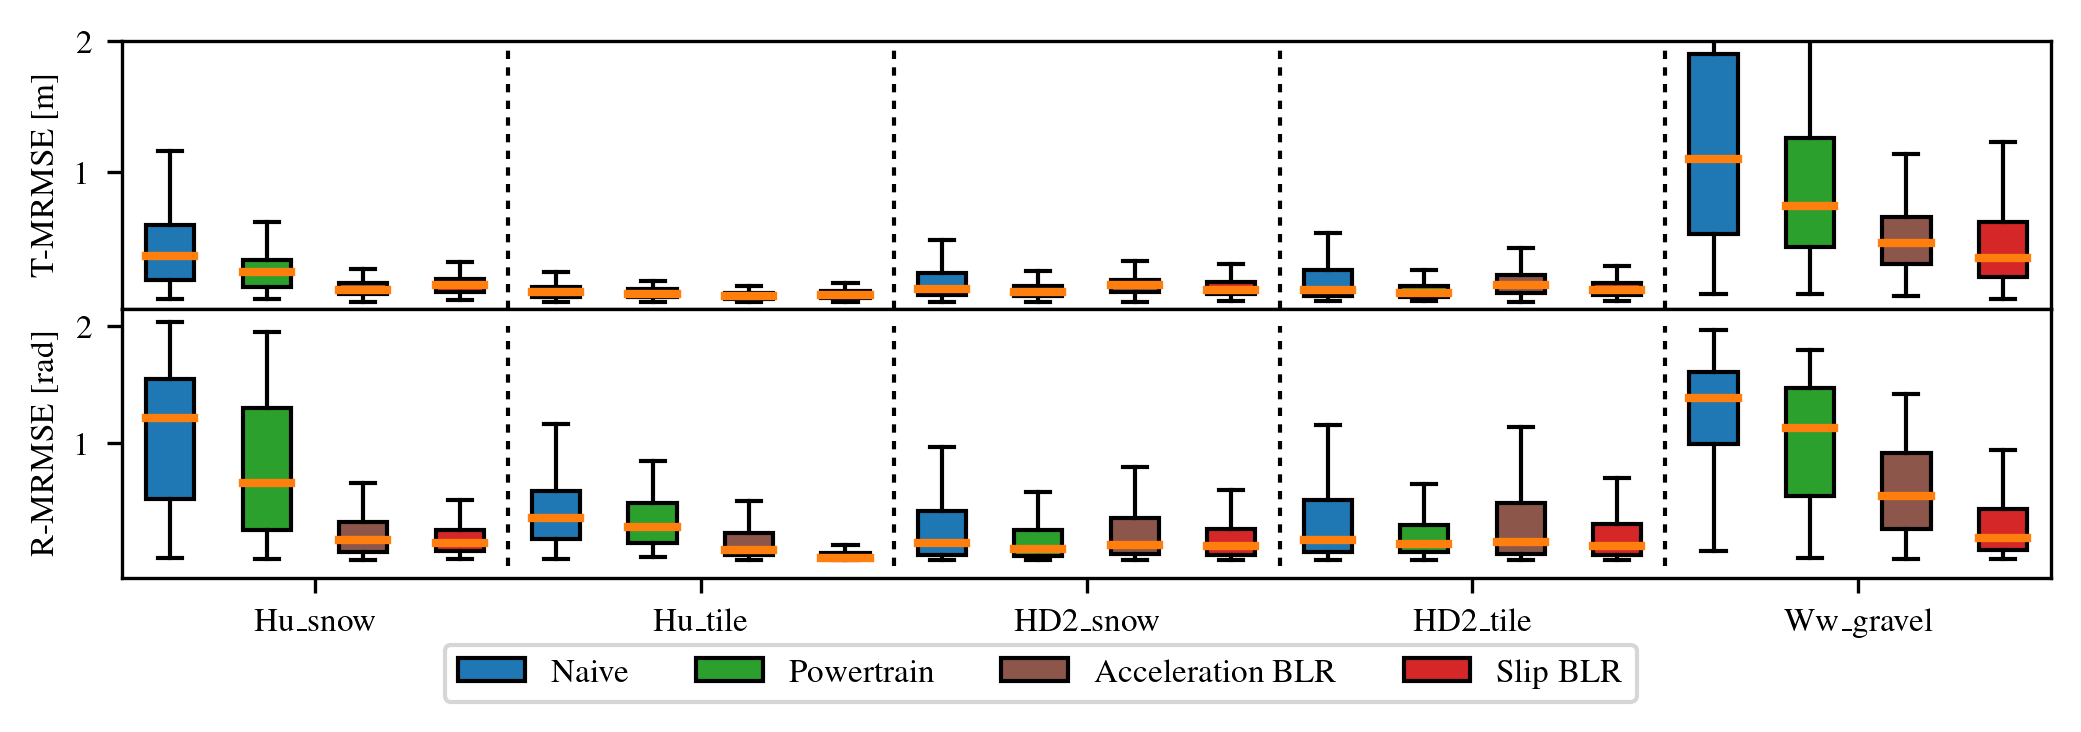

In [13]:
fig, axs = plt.subplots(2, 1, dpi=300, gridspec_kw={'hspace': 0.0, 'wspace': 0.0}, sharex=True)
fig.set_size_inches(2*width, height/1.25)
fig.subplots_adjust(left=.05, bottom=0.19, right=.995, top=.98)
# fig.tight_layout()

medians_color = 'C1'
cmd_box_color = 'C0'
powertrain_box_color = 'C2'
blr_slip_box_color = 'C3'
gp_slip_box_color = 'C4'
blr_slip_acceleration_box_color = 'C6'
blr_acceleration_box_color = 'C5'
boxplots_width = 0.5

y_max = 2
y_min = -0.05

for i in range(len(validate_datasets)):
    # print(cmd_idd_prediction_errors_list[i])
    cmd = axs[0].boxplot(cmd_idd_prediction_errors_list_translational[i], positions = [4*i], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = cmd_box_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

    # cmd = axs[0].violinplot(cmd_idd_prediction_errors_list_translational[i], positions = [4*i], widths=boxplots_width)
    # for pc in cmd['bodies']:
    #     pc.set_color(cmd_box_color)
    #     # pc.set_edgecolor('black')

    pwrtrn = axs[0].boxplot(transitory_idd_prediction_errors_list_translational[i], positions = [4*i+1], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = powertrain_box_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))


    blr_acceleration = axs[0].boxplot(blr_acceleration_prediction_errors_list_translational[i], positions = [4*i+2], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = blr_acceleration_box_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))



    blr_slip = axs[0].boxplot(blr_slip_prediction_errors_list_translational[i], positions = [4*i+3], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = blr_slip_box_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

    cmd_rot = axs[1].boxplot(cmd_idd_prediction_errors_list_rotational[i], positions = [4*i], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = cmd_box_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

    pwrtrn_rot = axs[1].boxplot(transitory_idd_prediction_errors_list_rotational[i], positions = [4*i+1], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = powertrain_box_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

    blr_acceleration_rot = axs[1].boxplot(blr_acceleration_prediction_errors_list_rotational[i], positions = [4*i+2], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = blr_acceleration_box_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

    blr_slip_rot = axs[1].boxplot(blr_slip_prediction_errors_list_rotational[i], positions = [4*i+3], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = blr_slip_box_color, color = 'k'),
                   whiskerprops=dict(color='k'),
                   medianprops=dict(color=medians_color, linewidth=2))

    # blr_slip_acceleration = axs[0].boxplot(blr_slip_acceleration_prediction_errors_list[i], positions = [6*i+4], widths=boxplots_width, showfliers=False, patch_artist=True,
    #                boxprops=dict(facecolor = blr_slip_acceleration_box_color, color = 'k'),
    #                whiskerprops=dict(color='k'),
    #                medianprops=dict(color=medians_color, linewidth=2))
    #
    # gp_slip = axs[0].boxplot(gp_slip_prediction_errors_list[i], positions = [6*i+5], widths=boxplots_width, showfliers=False, patch_artist=True,
    #                boxprops=dict(facecolor = gp_slip_box_color, color = 'k'),
    #                whiskerprops=dict(color='k'),
    #                medianprops=dict(color=medians_color, linewidth=2))


    if i<len(validate_datasets)-1:
        axs[0].vlines(4*i+3.5, y_min, y_max, colors='k', linestyles='dashed')
        axs[1].vlines(4*i+3.5, y_min, y_max, colors='k', linestyles='dashed')

axs[0].set_ylim(y_min, y_max)

xticks = []
for i in range(len(dataset_labels)):
    xticks.append(4.0*i+1.5)
axs[0].set_yticks([1, 2])
axs[1].set_yticks([1, 2])

axs[0].set_xticks(xticks)
axs[0].set_xticklabels(dataset_labels)
axs[0].set_ylabel(r'T-MRMSE [m]')
# axs[0].set_yscale('log')
# axs[0].set_title('Doughnut calib calibration results (2-second horizons)')

axs[1].set_xticks(xticks)
axs[1].set_xticklabels(dataset_labels)
axs[1].set_ylabel(r'R-MRMSE [rad]')
# axs[0].set_yscale('log')

# legend
legend_elements = [Rectangle((0,0), width=5, height=3, facecolor=cmd_box_color, label=r'Naive', linestyle='solid', edgecolor='k'),
                   Rectangle((0,0), width=5, height=3, facecolor=powertrain_box_color, label=r'Powertrain', linestyle='solid', edgecolor='k'),
                   Rectangle((0,0), width=5, height=3, facecolor=blr_acceleration_box_color, label=r'Acceleration BLR', linestyle='solid', edgecolor='k'),
                  Rectangle((0,0), width=5, height=3, facecolor=blr_slip_box_color, label=r'Slip BLR', linestyle='solid', edgecolor='k')]
                  #  Rectangle((0,0), width=5, height=3, facecolor=blr_slip_acceleration_box_color, label='Slip acceleration BLR', linestyle='solid', edgecolor='k'),
                  # Rectangle((0,0), width=5, height=3, facecolor=gp_slip_box_color, label='Slip GP', linestyle='solid', edgecolor='k')]

fig.legend(handles=legend_elements, loc='center', ncol=4, bbox_to_anchor=(0.5,0.05))

plt.savefig('figs/prediction_errors_BLR.pdf')

In [8]:
figure_datasets = [0, 3, 5]
cmd_other_datasets_translational_errors = np.array([])
cmd_other_datasets_rotational_errors = np.array([])
transitory_other_datasets_translational_errors = np.array([])
transitory_other_datasets_rotational_errors = np.array([])
slip_blr_other_datasets_translational_errors = np.array([])
slip_blr_other_datasets_rotational_errors = np.array([])
acceleration_blr_other_datasets_translational_errors = np.array([])
acceleration_blr_other_datasets_rotational_errors = np.array([])

cmd_all_datasets_translational_errors = np.array([])
cmd_all_datasets_rotational_errors = np.array([])
transitory_all_datasets_translational_errors = np.array([])
transitory_all_datasets_rotational_errors = np.array([])
slip_blr_all_datasets_translational_errors = np.array([])
slip_blr_all_datasets_rotational_errors = np.array([])
acceleration_blr_all_datasets_translational_errors = np.array([])
acceleration_blr_all_datasets_rotational_errors = np.array([])

for i in range(0, len(dataset_labels)):
    if i not in figure_datasets:
        cmd_other_datasets_translational_errors = np.concatenate((cmd_other_datasets_translational_errors,
                                                                  cmd_idd_prediction_errors_list_translational[i]))
        cmd_other_datasets_rotational_errors = np.concatenate((cmd_other_datasets_rotational_errors,
                                                                  cmd_idd_prediction_errors_list_rotational[i]))
        transitory_other_datasets_translational_errors = np.concatenate((transitory_other_datasets_translational_errors,
                                                                  transitory_idd_prediction_errors_list_translational[i]))
        transitory_other_datasets_rotational_errors = np.concatenate((transitory_other_datasets_rotational_errors,
                                                                  transitory_idd_prediction_errors_list_rotational[i]))
        slip_blr_other_datasets_translational_errors = np.concatenate((slip_blr_other_datasets_translational_errors,
                                                                  blr_slip_prediction_errors_list_translational[i]))
        slip_blr_other_datasets_rotational_errors = np.concatenate((slip_blr_other_datasets_rotational_errors,
                                                                  blr_slip_prediction_errors_list_rotational[i]))
        acceleration_blr_other_datasets_translational_errors = np.concatenate((acceleration_blr_other_datasets_translational_errors,
                                                                  blr_acceleration_prediction_errors_list_translational[i]))
        acceleration_blr_other_datasets_rotational_errors = np.concatenate((acceleration_blr_other_datasets_rotational_errors,
                                                                  blr_acceleration_prediction_errors_list_rotational[i]))

    cmd_all_datasets_translational_errors = np.concatenate((cmd_all_datasets_translational_errors,
                                                                  cmd_idd_prediction_errors_list_translational[i]))
    cmd_all_datasets_rotational_errors = np.concatenate((cmd_all_datasets_rotational_errors,
                                                              cmd_idd_prediction_errors_list_rotational[i]))
    transitory_all_datasets_translational_errors = np.concatenate((transitory_all_datasets_translational_errors,
                                                              transitory_idd_prediction_errors_list_translational[i]))
    transitory_all_datasets_rotational_errors = np.concatenate((transitory_all_datasets_rotational_errors,
                                                              transitory_idd_prediction_errors_list_rotational[i]))
    slip_blr_all_datasets_translational_errors = np.concatenate((slip_blr_all_datasets_translational_errors,
                                                              blr_slip_prediction_errors_list_translational[i]))
    slip_blr_all_datasets_rotational_errors = np.concatenate((slip_blr_all_datasets_rotational_errors,
                                                              blr_slip_prediction_errors_list_rotational[i]))
    acceleration_blr_all_datasets_translational_errors = np.concatenate((acceleration_blr_all_datasets_translational_errors,
                                                              blr_acceleration_prediction_errors_list_translational[i]))
    acceleration_blr_all_datasets_rotational_errors = np.concatenate((acceleration_blr_all_datasets_rotational_errors,
                                                              blr_acceleration_prediction_errors_list_rotational[i]))
print(cmd_other_datasets_translational_errors.shape)
print(transitory_other_datasets_rotational_errors.shape)

(689,)
(689,)


/var/folders/81/fnt9x6_x5l343vfsqmvf5fd40000gn/T/ipykernel_1231/2440080708.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('plasma')


[1.5, 5.5, 9.5, 13.5]


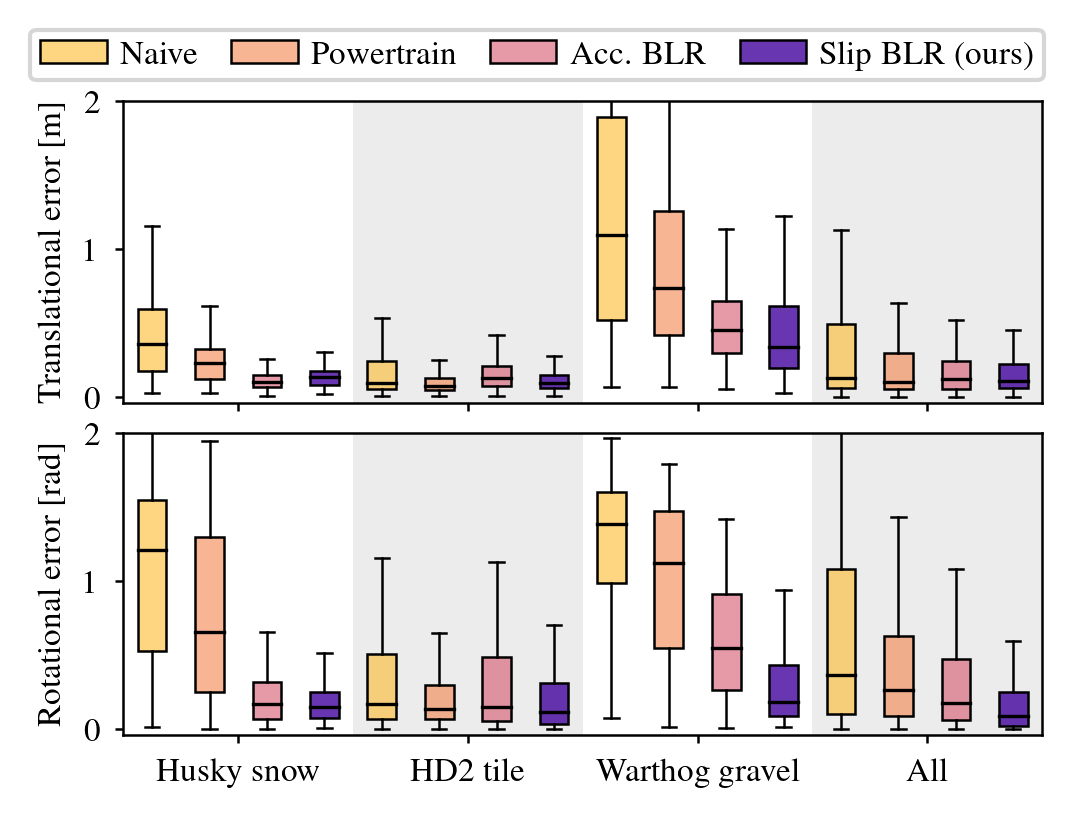

In [49]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
mpl.rcParams['lines.dashed_pattern'] = [2, 2]
#mpl.rcParams['lines.linewidth'] = 0.5

fig, axs = plt.subplots(2, 1, dpi=300, gridspec_kw={'hspace': 0.1, 'wspace': 0.0}, sharex=True)
fig.set_size_inches(width, height/1.1)
fig.subplots_adjust(left=.095, bottom=0.08, right=.995, top=.9)
# fig.tight_layout()

myWidth = 0.6

for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(myWidth)
    axs[1].spines[axis].set_linewidth(myWidth)

    axs[0].tick_params(direction='out', length=2)
    axs[1].tick_params(direction='out', length=2)

cmap_alpha = 0.6
cmap_alpha_darker = 0.8
cmap = mpl.cm.get_cmap('plasma')


###################################################  boxplot colors WITH alpha
cmd_box_color = cmap(0.85)                                                        # naive
cmd_box_color_list = list(cmd_box_color)
cmd_box_color_list[3] = cmap_alpha
cmd_box_color = tuple(cmd_box_color_list)

powertrain_box_color = cmap(0.7)                                                   # powertrain
powertrain_box_color_list = list(powertrain_box_color)
powertrain_box_color_list[3] = cmap_alpha
powertrain_box_color = tuple(powertrain_box_color_list)

blr_acceleration_box_color = cmap(0.55)                                            # acceleration BLR
blr_acceleration_box_color_list = list(blr_acceleration_box_color)
blr_acceleration_box_color_list[3] = cmap_alpha
blr_acceleration_box_color = tuple(blr_acceleration_box_color_list)

blr_slip_box_color = cmap(0.1)                                                      # ours
blr_slip_box_color_list = list(blr_slip_box_color)
blr_slip_box_color_list[3] = cmap_alpha_darker
blr_slip_box_color = tuple(blr_slip_box_color_list)
###################################################

medians_color = 'k'
medians_width = 0.8
gp_slip_box_color = 'C4'
blr_slip_acceleration_box_color = 'C6'
boxplots_width = 0.5


y_max = 2.5
y_min = -0.1

figure_datasets = [0, 3, 4]


for j in range(0, len(figure_datasets)):
    i = figure_datasets[j]
    # print(cmd_idd_prediction_errors_list[i])
    cmd = axs[0].boxplot(cmd_idd_prediction_errors_list_translational[i], positions = [4*j], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = cmd_box_color, color = 'k', linewidth=myWidth),
                   whiskerprops=dict(color='k', linewidth=myWidth),
                   medianprops=dict(color=medians_color, linewidth=medians_width),
                   capprops=dict(color='k', linewidth=myWidth))

    # cmd = axs[0].violinplot(cmd_idd_prediction_errors_list_translational[i], positions = [4*j], widths=boxplots_width)
    # for pc in cmd['bodies']:
    #     pc.set_color(cmd_box_color)
    #     # pc.set_edgecolor('black')

    pwrtrn = axs[0].boxplot(transitory_idd_prediction_errors_list_translational[i], positions = [4*j+1], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = powertrain_box_color, color = 'k', linewidth=myWidth),
                   whiskerprops=dict(color='k', linewidth=myWidth),
                   medianprops=dict(color=medians_color, linewidth=medians_width),
                   capprops=dict(color='k', linewidth=myWidth))


    blr_acceleration = axs[0].boxplot(blr_acceleration_prediction_errors_list_translational[i], positions = [4*j+2], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = blr_acceleration_box_color, color = 'k', linewidth=myWidth),
                   whiskerprops=dict(color='k', linewidth=myWidth),
                   medianprops=dict(color=medians_color, linewidth=medians_width),
                   capprops=dict(color='k', linewidth=myWidth))



    blr_slip = axs[0].boxplot(blr_slip_prediction_errors_list_translational[i], positions = [4*j+3], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = blr_slip_box_color, color = 'k', linewidth=myWidth),
                   whiskerprops=dict(color='k', linewidth=myWidth),
                   medianprops=dict(color=medians_color, linewidth=medians_width),
                   capprops=dict(color='k', linewidth=myWidth))

    cmd_rot = axs[1].boxplot(cmd_idd_prediction_errors_list_rotational[i], positions = [4*j], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = cmd_box_color, color = 'k', linewidth=myWidth),
                   whiskerprops=dict(color='k', linewidth=myWidth),
                   medianprops=dict(color=medians_color, linewidth=medians_width),
                   capprops=dict(color='k', linewidth=myWidth))

    pwrtrn_rot = axs[1].boxplot(transitory_idd_prediction_errors_list_rotational[i], positions = [4*j+1], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = powertrain_box_color, color = 'k', linewidth=myWidth),
                   whiskerprops=dict(color='k', linewidth=myWidth),
                   medianprops=dict(color=medians_color, linewidth=medians_width),
                   capprops=dict(color='k', linewidth=myWidth))

    blr_acceleration_rot = axs[1].boxplot(blr_acceleration_prediction_errors_list_rotational[i], positions = [4*j+2], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = blr_acceleration_box_color, color = 'k', linewidth=myWidth),
                   whiskerprops=dict(color='k', linewidth=myWidth),
                   medianprops=dict(color=medians_color, linewidth=medians_width),
                   capprops=dict(color='k', linewidth=myWidth))

    blr_slip_rot = axs[1].boxplot(blr_slip_prediction_errors_list_rotational[i], positions = [4*j+3], widths=boxplots_width, showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor = blr_slip_box_color, color = 'k', linewidth=myWidth),
                   whiskerprops=dict(color='k', linewidth=myWidth),
                   medianprops=dict(color=medians_color, linewidth=medians_width),
                   capprops=dict(color='k', linewidth=myWidth))

    # blr_slip_acceleration = axs[0].boxplot(blr_slip_acceleration_prediction_errors_list[i], positions = [6*i+4], widths=boxplots_width, showfliers=False, patch_artist=True,
    #                boxprops=dict(facecolor = blr_slip_acceleration_box_color, color = 'k'),
    #                whiskerprops=dict(color='k'),
    #                medianprops=dict(color=medians_color, linewidth=2))
    #
    # gp_slip = axs[0].boxplot(gp_slip_prediction_errors_list[i], positions = [6*i+5], widths=boxplots_width, showfliers=False, patch_artist=True,
    #                boxprops=dict(facecolor = gp_slip_box_color, color = 'k'),
    #                whiskerprops=dict(color='k'),
    #                medianprops=dict(color=medians_color, linewidth=2))


    #if j<len(figure_datasets):
    #   axs[0].vlines(4*j+3.5, y_min, y_max, colors='k', linestyles='dashed', linewidth=myWidth)
    #   axs[1].vlines(4*j+3.5, y_min, y_max, colors='k', linestyles='dashed', linewidth=myWidth)



cmd = axs[0].boxplot(cmd_other_datasets_translational_errors, positions = [4*len(figure_datasets)], widths=boxplots_width, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor = cmd_box_color, color = 'k', linewidth=myWidth),
               whiskerprops=dict(color='k', linewidth=myWidth),
               medianprops=dict(color=medians_color, linewidth=medians_width),
               capprops=dict(color='k', linewidth=myWidth))

pwrtrn = axs[0].boxplot(transitory_other_datasets_translational_errors, positions = [4*len(figure_datasets)+1], widths=boxplots_width, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor = powertrain_box_color, color = 'k', linewidth=myWidth),
               whiskerprops=dict(color='k', linewidth=myWidth),
               medianprops=dict(color=medians_color, linewidth=medians_width),
               capprops=dict(color='k', linewidth=myWidth))


blr_acceleration = axs[0].boxplot(acceleration_blr_other_datasets_translational_errors, positions = [4*len(figure_datasets)+2], widths=boxplots_width, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor = blr_acceleration_box_color, color = 'k', linewidth=myWidth),
               whiskerprops=dict(color='k', linewidth=myWidth),
               medianprops=dict(color=medians_color, linewidth=medians_width),
               capprops=dict(color='k', linewidth=myWidth))



blr_slip = axs[0].boxplot(slip_blr_other_datasets_translational_errors, positions = [4*len(figure_datasets)+3], widths=boxplots_width, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor = blr_slip_box_color, color = 'k', linewidth=myWidth),
               whiskerprops=dict(color='k', linewidth=myWidth),
               medianprops=dict(color=medians_color, linewidth=medians_width),
               capprops=dict(color='k', linewidth=myWidth))

cmd_rot = axs[1].boxplot(cmd_other_datasets_rotational_errors, positions = [4*len(figure_datasets)], widths=boxplots_width, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor = cmd_box_color, color = 'k', linewidth=myWidth),
               whiskerprops=dict(color='k', linewidth=myWidth),
               medianprops=dict(color=medians_color, linewidth=medians_width),
               capprops=dict(color='k', linewidth=myWidth))

pwrtrn_rot = axs[1].boxplot(transitory_other_datasets_rotational_errors, positions = [4*len(figure_datasets)+1], widths=boxplots_width, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor = powertrain_box_color, color = 'k', linewidth=myWidth),
               whiskerprops=dict(color='k', linewidth=myWidth),
               medianprops=dict(color=medians_color, linewidth=medians_width),
               capprops=dict(color='k', linewidth=myWidth))

blr_acceleration_rot = axs[1].boxplot(acceleration_blr_other_datasets_rotational_errors, positions = [4*len(figure_datasets)+2], widths=boxplots_width, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor = blr_acceleration_box_color, color = 'k', linewidth=myWidth),
               whiskerprops=dict(color='k', linewidth=myWidth),
               medianprops=dict(color=medians_color, linewidth=medians_width),
               capprops=dict(color='k', linewidth=myWidth))

blr_slip_rot = axs[1].boxplot(slip_blr_other_datasets_rotational_errors, positions = [4*len(figure_datasets)+3], widths=boxplots_width, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor = blr_slip_box_color, color = 'k', linewidth=myWidth),
               whiskerprops=dict(color='k', linewidth=myWidth),
               medianprops=dict(color=medians_color, linewidth=medians_width),
               capprops=dict(color='k', linewidth=myWidth))

axs[0].set_ylim(-0.04, 2)
axs[1].set_ylim(-0.04, 2)

for i in range(len(axs)):
    axs[i].add_patch(Rectangle((3.5, -0.04), 4, 2.04, edgecolor='none', facecolor='gray', alpha=0.15))
    axs[i].add_patch(Rectangle((3.5+8, -0.04), 4, 2.04, edgecolor='none', facecolor='gray', alpha=0.15))

xticks = []
for i in range(len(figure_datasets) + 1):
    xticks.append(4.0*i+1.5)

axs[0].tick_params(width=myWidth)
axs[1].tick_params(width=myWidth)

print(xticks)
axs[0].set_xticks(xticks)
axs[1].set_xticklabels(['Husky snow', 'HD2 tile', 'Warthog gravel', 'All'])

# axs[0].set_yticks([1, 2])
# axs[1].set_yticks([1, 2])


axs[0].set_ylabel(r'Translational error [m]')
# axs[0].set_yscale('log')
# axs[0].set_title('Doughnut calib calibration results (2-second horizons)')

axs[1].set_ylabel(r'Rotational error [rad]')
# axs[0].set_yscale('log')


# legend
legend_elements = [Rectangle((0,0), width=5, height=3, facecolor=cmd_box_color, label=r'Naive', linestyle='solid', edgecolor='k', linewidth=myWidth),
                   Rectangle((0,0), width=5, height=3, facecolor=powertrain_box_color, label=r'Powertrain', linestyle='solid', edgecolor='k', linewidth=myWidth),
                   Rectangle((0,0), width=5, height=3, facecolor=blr_acceleration_box_color, label=r'Acc. BLR', linestyle='solid', edgecolor='k', linewidth=myWidth),
                   Rectangle((0,0), width=10, height=3, facecolor=blr_slip_box_color, label=r'Slip BLR (ours)', linestyle='solid', edgecolor='k', linewidth=myWidth)]
                  #  Rectangle((0,0), width=5, height=3, facecolor=blr_slip_acceleration_box_color, label='Slip acceleration BLR', linestyle='solid', edgecolor='k'),
                  # Rectangle((0,0), width=5, height=3, facecolor=gp_slip_box_color, label='Slip GP', linestyle='solid', edgecolor='k')]

fig.legend(handles=legend_elements, loc='center', ncol=4, bbox_to_anchor=(0.5,0.96), columnspacing=1, handletextpad=0.4, alignment='center', borderpad=0.3,
           handleheight=0.7)

plt.savefig('figs/prediction_errors_BLR_cg_v3.pdf')
plt.savefig('figs/prediction_errors_BLR_cg_v3.jpg', dpi=500)

In [112]:
# compute eval metrics

husky_translation_improvement = (np.median(cmd_idd_prediction_errors_list_translational[0]) - np.median(blr_slip_prediction_errors_list_translational[0])) / np.median(cmd_idd_prediction_errors_list_translational[0]) * 100
husky_rotation_improvement = (np.median(cmd_idd_prediction_errors_list_rotational[0]) - np.median(blr_slip_prediction_errors_list_rotational[0])) / np.median(cmd_idd_prediction_errors_list_rotational[0]) * 100

print('Husky Translation prediciton improvement : ', husky_translation_improvement,  ' %')
print('Husky Rotation prediciton improvement : ', husky_rotation_improvement, ' %')

hd2_translation_improvement = (np.median(cmd_idd_prediction_errors_list_translational[3]) - np.median(blr_slip_prediction_errors_list_translational[3])) / np.median(cmd_idd_prediction_errors_list_translational[3]) * 100
hd2_rotation_improvement = (np.median(cmd_idd_prediction_errors_list_rotational[3]) - np.median(blr_slip_prediction_errors_list_rotational[3])) / np.median(cmd_idd_prediction_errors_list_rotational[3]) * 100

print('HD2 Translation prediciton improvement : ', hd2_translation_improvement,  ' %')
print('HD2 Rotation prediciton improvement : ', hd2_rotation_improvement, ' %')

warthog_translation_improvement = (np.median(cmd_idd_prediction_errors_list_translational[4]) - np.median(blr_slip_prediction_errors_list_translational[4])) / np.median(cmd_idd_prediction_errors_list_translational[4]) * 100
warthog_rotation_improvement = (np.median(cmd_idd_prediction_errors_list_rotational[4]) - np.median(blr_slip_prediction_errors_list_rotational[4])) / np.median(cmd_idd_prediction_errors_list_rotational[4]) * 100

print('Warthog Translation prediciton improvement : ', warthog_translation_improvement,  ' %')
print('Warthog Rotation prediciton improvement : ', warthog_rotation_improvement, ' %')

all_translation_improvement = (np.median(cmd_all_datasets_translational_errors) - np.median(slip_blr_all_datasets_translational_errors)) / np.median(cmd_all_datasets_translational_errors) * 100
all_rotation_improvement = (np.median(cmd_all_datasets_rotational_errors) - np.median(slip_blr_all_datasets_rotational_errors)) / np.median(cmd_all_datasets_rotational_errors) * 100

print('All Translation prediciton improvement : ', all_translation_improvement,  ' %')
print('All Rotation prediciton improvement : ', all_rotation_improvement, ' %')

all_translation_learning_improvement = (np.median(acceleration_blr_all_datasets_translational_errors) - np.median(slip_blr_all_datasets_translational_errors)) / np.median(acceleration_blr_all_datasets_translational_errors) * 100
all_rotation_learning_improvement = (np.median(acceleration_blr_all_datasets_rotational_errors) - np.median(slip_blr_all_datasets_rotational_errors)) / np.median(acceleration_blr_all_datasets_rotational_errors) * 100

print('All learning Translation prediciton improvement : ', all_translation_learning_improvement,  ' %')
print('All learning Rotation prediciton improvement : ', all_rotation_learning_improvement, ' %')

all_powertrain_translation_learning_improvement = (np.median(cmd_all_datasets_translational_errors) - np.median(transitory_all_datasets_translational_errors)) / np.median(cmd_all_datasets_translational_errors) * 100
all_powertrain_rotation_learning_improvement = (np.median(cmd_all_datasets_rotational_errors) - np.median(transitory_all_datasets_rotational_errors)) / np.median(cmd_all_datasets_rotational_errors) * 100

print('All powertrain Translation prediciton improvement : ', all_powertrain_translation_learning_improvement,  ' %')
print('All powertrain Rotation prediciton improvement : ', all_powertrain_rotation_learning_improvement, ' %')

hd2_translation_decrease_acceleration_blr = (np.median(transitory_idd_prediction_errors_list_translational[3]) - np.median(blr_acceleration_prediction_errors_list_translational[3])) / np.median(transitory_idd_prediction_errors_list_translational[3]) * 100
hd2_rotation_decrease_acceleration_blr = (np.median(transitory_idd_prediction_errors_list_rotational[3]) - np.median(blr_acceleration_prediction_errors_list_rotational[3])) / np.median(transitory_idd_prediction_errors_list_rotational[3]) * 100

print('HD2 Translation prediciton decrease_acceleration_blr : ', hd2_translation_decrease_acceleration_blr,  ' %')
print('HD2 Rotation prediciton decrease_acceleration_blr : ', hd2_rotation_decrease_acceleration_blr, ' %')

hd2_translation_decrease_slip_blr = (np.median(transitory_idd_prediction_errors_list_translational[3]) - np.median(blr_slip_prediction_errors_list_translational[3])) / np.median(transitory_idd_prediction_errors_list_translational[3]) * 100
hd2_rotation_decrease_slip_blr = (np.median(transitory_idd_prediction_errors_list_rotational[3]) - np.median(blr_slip_prediction_errors_list_rotational[3])) / np.median(transitory_idd_prediction_errors_list_rotational[3]) * 100

print('HD2 Translation prediciton decrease_slip_blr : ', hd2_translation_decrease_slip_blr,  ' %')
print('HD2 Rotation prediciton decrease_slip_blr : ', hd2_rotation_decrease_slip_blr, ' %')

Husky Translation prediciton improvement :  62.43871131619575  %
Husky Rotation prediciton improvement :  87.6667664255554  %
HD2 Translation prediciton improvement :  -1.1067059560094301  %
HD2 Rotation prediciton improvement :  28.813730137121556  %
Warthog Translation prediciton improvement :  69.03377754193907  %
Warthog Rotation prediciton improvement :  86.5893560893701  %
All Translation prediciton improvement :  25.914086357018178  %
All Rotation prediciton improvement :  71.28934248902901  %
All learning Translation prediciton improvement :  -0.202881949297979  %
All learning Rotation prediciton improvement :  29.246414384794495  %
All powertrain Translation prediciton improvement :  25.953549996537195  %
All powertrain Rotation prediciton improvement :  35.872044697005826  %
HD2 Translation prediciton decrease_acceleration_blr :  -78.42469136962262  %
HD2 Rotation prediciton decrease_acceleration_blr :  -12.798135576074102  %
HD2 Translation prediciton decrease_slip_blr :  -2

In [ ]:
plt.hist(blr_slip_prediction_errors_list_translational[-1])
plt.hist(blr_acceleration_prediction_errors_list_translational[-1])



(array([22., 26., 24., 20., 22., 16., 19., 19., 10.,  2.]),
 array([0.00701211, 0.14820865, 0.28940519, 0.43060173, 0.57179827,
        0.71299482, 0.85419136, 0.9953879 , 1.13658444, 1.27778098,
        1.41897753]),
 <BarContainer object of 10 artists>)

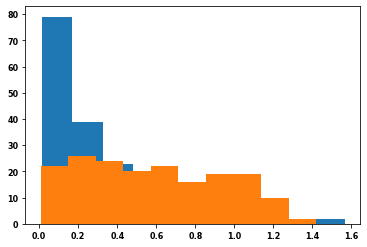

In [9]:
plt.hist(blr_slip_prediction_errors_list_rotational[-1])
plt.hist(blr_acceleration_prediction_errors_list_rotational[-1])

3.883952231333138
5.062723855380253
4.0148531038033495
4.537692324217692
16.17483884285745


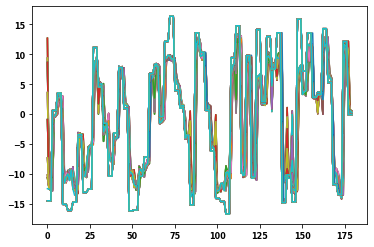

In [84]:
# compute M-RMSE for longer horizons


def compute_single_step_error(meas_state, pred_state):
    pred_error = meas_state - pred_state
    pred_error[2] = wrap2pi(pred_error[2]) # wrap yaw angle error to pi
    pred_error_squared_scalar = pred_error.T @ np.array([[0, 0, 0], [0.0, 0, 0], [0, 0, 1.0]]) @ pred_error
    return np.sqrt(pred_error_squared_scalar)

def horizon_mrsme(meas_states, pred_states):
    n_predictions = meas_states.shape[0]
    prediction_error_sum = 0
    for i in range(0, n_predictions):
        prediction_error_sum += compute_single_step_error(meas_states[i], pred_states[i])
    return np.sqrt(prediction_error_sum / n_predictions)

window_size = 40 * 3

def compute_prediction_metrics(validate_dataset, robot, blr_param_path, gp_param_path, blr_acceleration_param_path, blr_slip_acceleration_param_path):
    n_test_windows = len(validate_dataset)

    cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
    cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()
    transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
    transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()
    idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
    idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
    idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()
    icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
    icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
    icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()
    icp_vel_x_array = validate_dataset[str_icp_vel_x_list].to_numpy()
    icp_vel_y_array = validate_dataset[str_icp_vel_y_list].to_numpy()
    icp_vel_yaw_array = validate_dataset[str_icp_vel_yaw_list].to_numpy()

    body_vel_disturption_x_array = validate_dataset[str_body_vel_disturption_x_list].to_numpy()
    body_vel_disturption_y_array = validate_dataset[str_body_vel_disturption_y_list].to_numpy()
    body_vel_disturption_yaw_array = validate_dataset[str_body_vel_disturption_yaw_list].to_numpy()

    if robot=='H':
        wheel_radius = 0.33 / 2
        baseline = 0.55
        dt = 0.05
    if robot=='M':
        wheel_radius = 0.116
        baseline = 0.5927
        dt=0.05
    if robot == 'W':
        wheel_radius = 0.3
        baseline = 1.1652
        dt = 0.05

    slip_input_dimensions = 2
    a_param_init = 0
    b_param_init = 0
    param_variance_init = 999999999999999999999
    variance_init = 1000000000
    kappa_param = 1

    ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt)
    full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    full_body_slip_blr.load_params(blr_param_path)

    full_body_slip_acceleration_blr = FullBodySlipAccelerationBayesianLinearRegression(2, 1, 4, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    full_body_slip_acceleration_blr.load_params(blr_slip_acceleration_param_path)

    length_scales_x = [0.1]
    length_scales_y = [0.1]
    length_scales_yaw = [100]
    noise_levels_x = 0.1
    noise_levels_y = 0.1
    noise_levels_yaw = 0.5
    n_restarts_optimizer = 20

    full_body_slip_gp = FullBodySlipGaussianProcess(1, 1, 3, length_scales_x, length_scales_y, length_scales_yaw,
                 noise_levels_x, noise_levels_y, noise_levels_yaw, n_restarts_optimizer, baseline, wheel_radius, dt, kappa_param)
    full_body_slip_gp.load_params(gp_param_path)

    full_body_acceleration_blr = FullBodyAccelerationBayesianLinearRegression(2, 2, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)

    full_body_acceleration_blr.load_params(blr_acceleration_param_path)

    blr_predictions = np.zeros((int(n_test_windows/3), window_size, 3))
    gp_predictions = np.zeros((int(n_test_windows/3), window_size, 3))
    idd_predictions = np.zeros((int(n_test_windows/3), window_size, 3))
    cmd_input_horizon = np.zeros((2, window_size))
    transitory_input_horizon = np.zeros((2, window_size))
    cmd_body_vel_horizon = np.zeros((2, window_size))
    transitory_body_vel_horizon = np.zeros((3, window_size))
    blr_slip_body_vel_horizon = np.zeros((3, window_size))
    gp_slip_body_vel_horizon = np.zeros((3, window_size))

    cmd_idd_horizon_prediction = np.zeros((3, window_size))
    transitory_idd_horizon_prediction = np.zeros((3, window_size))
    blr_slip_horizon_prediction = np.zeros((3, window_size))
    gp_slip_horizon_prediction = np.zeros((3, window_size))
    blr_slip_acceleration_horizon_prediction = np.zeros((3, window_size))
    acceleration_horizon_prediction = np.zeros((3, window_size))
    acceleration_blr_horizon_prediction = np.zeros((3, window_size))
    icp_horizon_meas = np.zeros((3, window_size))
    icp_vel_meas = np.zeros((3, window_size))

    cmd_idd_prediction_errors = np.zeros(int(n_test_windows/3))
    transitory_idd_prediction_errors = np.zeros(int(n_test_windows/3))
    blr_slip_prediction_errors = np.zeros(int(n_test_windows/3))
    gp_slip_prediction_errors = np.zeros(int(n_test_windows/3))
    blr_slip_acceleration_prediction_errors = np.zeros(int(n_test_windows/3))
    blr_acceleration_prediction_errors = np.zeros(int(n_test_windows/3))
    idd_body_vels_array = np.zeros((window_size, 3))
    blr_init_state_covariance = np.eye(3) * 0.1
    gp_init_state_covariance = np.eye(3) * 0.1
    acceleration_blr_init_state_covariance = np.eye(3) * 0.1
    acceleration_blr_init_vel_covariance = np.eye(3) * 0.1

    for j in range(2, n_test_windows-3, 3):
        cmd_input_horizon[0, :] = cmd_left_vels_array[j:j+3, :].flatten()
        cmd_input_horizon[1, :] = cmd_right_vels_array[j:j+3, :].flatten()

        transitory_input_horizon[0, :] = transitory_left_vels_array[j:j+3, :].flatten()
        transitory_input_horizon[1, :] = transitory_right_vels_array[j:j+3, :].flatten()

        transitory_body_vel_horizon[0, :] = idd_body_vel_x_array[j:j+3, :].flatten()
        transitory_body_vel_horizon[1, :] = idd_body_vel_y_array[j:j+3, :].flatten()
        transitory_body_vel_horizon[2, :] = idd_body_vel_yaw_array[j:j+3, :].flatten()

        icp_x_window = icp_x_array[j:j+3,:].flatten()
        icp_y_window = icp_y_array[j:j+3,:].flatten()
        icp_yaw_window = icp_yaw_array[j:j+3,:].flatten()

        cmd_idd_horizon_prediction_error = 0
        transitory_idd_horizon_prediction_error = 0
        blr_horizon_prediction_error = 0
        gp_horizon_prediction_error = 0
        blr_slip_acceleration_horizon_prediction_error = 0
        blr_acceleration_horizon_prediction_error = 0

        for i in range(0, window_size-1):
            icp_2d_state = np.array([icp_x_window[i], icp_y_window[i], icp_yaw_window[i]])

            cmd_idd_horizon_prediction[:, i+1] = ideal_diff_drive.predict_2d(cmd_idd_horizon_prediction[:, i], cmd_input_horizon[:, i])
            cmd_idd_horizon_prediction_error += compute_single_step_error(icp_2d_state, cmd_idd_horizon_prediction[:, i])

            transitory_idd_horizon_prediction[:, i+1] = ideal_diff_drive.predict_2d(transitory_idd_horizon_prediction[:, i], transitory_input_horizon[:, i])
            transitory_idd_horizon_prediction_error += compute_single_step_error(icp_2d_state, transitory_idd_horizon_prediction[:, i])

        idd_body_vels_array[:, 0] = idd_body_vel_x_array[j:j+3, :].flatten()
        idd_body_vels_array[:, 1] = idd_body_vel_y_array[j:j+3, :].flatten()
        idd_body_vels_array[:, 2] = idd_body_vel_yaw_array[j:j+3, :].flatten()

        icp_vel_meas[0, :] = icp_vel_x_array[j:j+3, :].flatten()
        icp_vel_meas[1, :] = icp_vel_y_array[j:j+3, :].flatten()
        icp_vel_meas[2, :] = icp_vel_yaw_array[j:j+3, :].flatten()

        prediction_means_blr, prediction_covariances_blr = full_body_slip_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array,
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)
        prediction_means_gp, prediction_covariances_gp = full_body_slip_gp.predict_horizon_from_body_idd_vels(idd_body_vels_array,
                                                                                                        gp_slip_horizon_prediction[:, 0], gp_init_state_covariance)

        prediction_means_blr_slip_acceleration, prediction_covariances_blr_slip_acceleration = full_body_slip_acceleration_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array,
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)

        try:
            prediction_means_acceleration_blr, prediction_covariances_acceleration_blr = full_body_acceleration_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array, acceleration_horizon_prediction[:, 0], acceleration_blr_init_state_covariance, icp_vel_meas[:, 0],acceleration_blr_init_vel_covariance)
        except:
            print(robot)
            print('bug here')
            prediction_means_acceleration_blr, prediction_covariances_acceleration_blr = full_body_slip_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array,
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)

        icp_horizon_meas[0, :] = icp_x_array[j:j+3, :].flatten()
        icp_horizon_meas[1, :] = icp_y_array[j:j+3, :].flatten()
        icp_horizon_meas[2, :] = icp_yaw_array[j:j+3, :].flatten()

        icp_2d_state_rotated = np.zeros(3)
        last_icp_state_rotmat = np.eye(2)

        for i in range(0, window_size):
            # todo: transform icp state into previous window
            icp_2d_state = np.array([icp_x_window[i], icp_y_window[i], icp_yaw_window[i]])

            if i >= 20 and i<40:
                last_icp_state = np.array([icp_x_window[19], icp_y_window[19], icp_yaw_window[19]])
                yaw_to_rotmat2d(last_icp_state_rotmat, last_icp_state[2])
                icp_2d_state_rotated[:2] = np.linalg.inv(last_icp_state_rotmat) @ icp_2d_state[:2]
                icp_2d_state = icp_2d_state_rotated + last_icp_state
            if i >= 40:
                last_icp_state = np.array([icp_x_window[39], icp_y_window[39], icp_yaw_window[39]])
                yaw_to_rotmat2d(last_icp_state_rotmat, last_icp_state[2])
                icp_2d_state_rotated[:2] = np.linalg.inv(last_icp_state_rotmat) @ icp_2d_state[:2]
                icp_2d_state = icp_2d_state_rotated + last_icp_state
            blr_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means_blr[:, i])
            gp_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means_gp[:, i])
            blr_slip_acceleration_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means_blr_slip_acceleration[:, i])
            blr_acceleration_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means_acceleration_blr[:, i])

        # blr_msre = np.diag(blr_prediction_errors @ blr_prediction_errors.T)
        # blr_slip_prediction_errors[j] = np.sqrt(np.sqrt((blr_msre.T @ blr_msre) / window_size))

        # print('blr : ', prediction_means_blr[2, -1])
        # print('icp : ', icp_horizon_meas[2, -1])


        cmd_idd_prediction_errors[int(j/3)] = cmd_idd_horizon_prediction_error / window_size
        transitory_idd_prediction_errors[int(j/3)] = transitory_idd_horizon_prediction_error / window_size
        blr_slip_prediction_errors[int(j/3)] = blr_horizon_prediction_error / window_size
        gp_slip_prediction_errors[int(j/3)] = gp_horizon_prediction_error / window_size
        blr_acceleration_prediction_errors[int(j/3)] = blr_acceleration_horizon_prediction_error / window_size
        blr_slip_acceleration_prediction_errors[int(j/3)] = blr_slip_acceleration_horizon_prediction_error / window_size

    return cmd_idd_prediction_errors, transitory_idd_prediction_errors, blr_slip_prediction_errors, gp_slip_prediction_errors, blr_slip_acceleration_prediction_errors, blr_acceleration_prediction_errors

cmd_idd_prediction_errors_list = []
transitory_idd_prediction_errors_list = []
blr_slip_prediction_errors_list = []
gp_slip_prediction_errors_list = []
blr_slip_acceleration_prediction_errors_list = []
blr_acceleration_prediction_errors_list = []
for i in range(len(validate_datasets)):
    validate_dataset = validate_datasets[i]
    dataset_label = dataset_labels[i]
    robot = dataset_label.split('_')[0]
    blr_slip_param_path = blr_slip_param_paths[i]
    gp_param_path = gp_slip_param_paths[i]
    blr_slip_acceleration_param_path = blr_slip_acceleration_param_paths[i]
    blr_acceleration_param_path = blr_acceleration_param_paths[i]

    cmd_idd_prediction_errors, transitory_idd_prediction_errors, blr_slip_prediction_errors, gp_slip_prediction_errors, blr_slip_acceleration_prediction_errors, blr_acceleration_prediction_errors = compute_prediction_metrics(validate_dataset, robot, blr_slip_param_path, gp_param_path, blr_acceleration_param_path, blr_slip_acceleration_param_path)
    cmd_idd_prediction_errors_list.append(cmd_idd_prediction_errors)
    transitory_idd_prediction_errors_list.append(transitory_idd_prediction_errors)
    blr_slip_prediction_errors_list.append(blr_slip_prediction_errors)
    gp_slip_prediction_errors_list.append(gp_slip_prediction_errors)
    blr_slip_acceleration_prediction_errors_list.append(blr_slip_acceleration_prediction_errors)
    blr_acceleration_prediction_errors_list.append(blr_acceleration_prediction_errors)
    print(robot)

11.529300920705888
6.845590985623384
11.658570796617447
6.8793787632545165
16.17483884285745


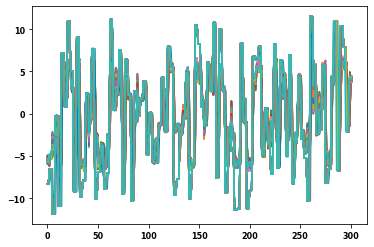

In [8]:
# evaluate error with respect to number of training timesteps

validate_dataset = validate_datasets[6]
train_dataset = train_datasets[6]
n_test_windows = len(validate_dataset)

full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)

# saved_params_root_path = '../data/ral2023_dataset/husky/boreal_snow/trained_params/slip/blr/steady-state/growing_training_set/'
saved_params_root_path = '../data/ral2023_dataset/warthog_tracks/boreal_mud/trained_params/slip/blr/steady-state/growing_training_set/'

blr_slip_prediction_errors_training_timesteps_list = []

cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()
transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()
idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()
icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()
body_vel_disturption_x_array = validate_dataset[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = validate_dataset[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = validate_dataset[str_body_vel_disturption_yaw_list].to_numpy()

idd_body_vels_array = np.zeros((window_size, 3))
blr_slip_horizon_prediction = np.zeros((3, window_size))
blr_init_state_covariance = np.zeros((3,3))
# translation_init_covariance = 0.005
# rotation_init_covariance = 0.05
translation_init_covariance = 0.01
rotation_init_covariance = 0.03
blr_init_state_covariance[0,0] = translation_init_covariance
blr_init_state_covariance[1,1] = translation_init_covariance
blr_init_state_covariance[2,2] = rotation_init_covariance
blr_slip_prediction_z_scores_translational = np.zeros(n_test_windows)
blr_slip_prediction_z_scores_rotational = np.zeros(n_test_windows)

x_logspace = np.logspace(3, int(len(train_dataset)*40*2/3), num = 100, base = 1.01)
print(x_logspace)

for i in x_logspace:
    i = int(i)
    print(str(i) + ' / ' + str(int(len(train_dataset)*40*2/3)))
    robot = 'H'
    blr_slip_param_path = saved_params_root_path + str(i) + '/'
    # cmd_idd_prediction_errors, transitory_idd_prediction_errors, blr_slip_prediction_errors = compute_prediction_metrics(validate_dataset, robot, blr_slip_param_path)
    # blr_slip_prediction_errors_training_timesteps_list.append(blr_slip_prediction_errors)
    
    n_test_windows = len(validate_dataset)
    
    blr_slip_prediction_errors = np.zeros(n_test_windows)
    
    if robot=='H':
        wheel_radius = 0.33 / 2
        baseline = 0.55
        dt = 0.05
    if robot=='M':
        wheel_radius = 0.116
        baseline = 0.5927
        dt=0.05
    if robot == 'W':
        wheel_radius = 0.3
        baseline = 1.1652
        dt = 0.05
        
    slip_input_dimensions = 2
    a_param_init = 0
    b_param_init = 0
    param_variance_init = 999999999999999999999
    variance_init = 1000000000
    kappa_param = 2
    
    icp_horizon_meas = np.zeros((3, window_size))
    
    ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt)
    full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    full_body_slip_blr.load_params(blr_slip_param_path)
    print('weights_x : ', full_body_slip_blr.body_x_slip_blr.weights)
    print('weights_y : ', full_body_slip_blr.body_y_slip_blr.weights)
    print('weights_yaw : ', full_body_slip_blr.body_yaw_slip_blr.weights)
    
    for j in range(0, n_test_windows):

        blr_horizon_prediction_error = 0

        idd_body_vels_array[:, 0] = idd_body_vel_x_array[j, :]
        idd_body_vels_array[:, 1] = idd_body_vel_y_array[j, :]
        idd_body_vels_array[:, 2] = idd_body_vel_yaw_array[j, :]
        
        # start = time.time()
        prediction_means, prediction_covariances = full_body_slip_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array, 
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)
        # end = time.time()
        # print('pred : ', start-end)
        
        for i in range(0, window_size):
            icp_2d_state = np.array([icp_x_array[j, i], icp_y_array[j, i], icp_yaw_array[j, i]])
            blr_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means[:, i])
        
        blr_slip_prediction_errors[j] = blr_horizon_prediction_error / window_size
    blr_slip_prediction_errors_training_timesteps_list.append(blr_slip_prediction_errors)
    

[1.03030100e+00 1.71382032e+00 2.85079806e+00 4.74206628e+00
 7.88803423e+00 1.31210912e+01 2.18258476e+01 3.63054886e+01
 6.03911711e+01 1.00455708e+02 1.67099744e+02 2.77956574e+02
 4.62357723e+02 7.69093752e+02 1.27932371e+03 2.12804896e+03
 3.53983307e+03 5.88821892e+03 9.79456414e+03 1.62924456e+04
 2.71011330e+04 4.50804885e+04 7.49876562e+04 1.24735751e+05
 2.07487583e+05 3.45138397e+05 5.74109118e+05 9.54982935e+05
 1.58853496e+06 2.64239624e+06 4.39540714e+06 7.31139548e+06
 1.21619004e+07 2.02303133e+07 3.36514494e+07 5.59763970e+07
 9.31120969e+07 1.54884256e+08 2.57637122e+08 4.28558000e+08
 7.12870712e+08 1.18580135e+09 1.97248226e+09 3.28106075e+09
 5.45777261e+09 9.07855238e+09 1.51014194e+10 2.51199596e+10
 4.17849708e+10 6.95058356e+10 1.15617197e+11 1.92319624e+11
 3.19907755e+11 5.32140035e+11 8.85170844e+11 1.47240833e+12
 2.44922922e+12 4.07408982e+12 6.77691074e+12 1.12728293e+13
 1.87514173e+13 3.11914285e+13 5.18843560e+13 8.63053259e+13
 1.43561756e+14 2.388030

LinAlgError: Matrix is not positive definite

In [ ]:
# weights_x :  [[-0.12538497]]
# weights_y :  [[-0.01996453]]
# weights_yaw :  [[ 0.31519004]
#  [-2.05371261]
#  [ 0.28661516]]

blr_training_timesteps_means = np.zeros(len(blr_slip_prediction_errors_training_timesteps_list))
blr_training_timesteps_first_quantiles = np.zeros(len(blr_slip_prediction_errors_training_timesteps_list))
blr_training_timesteps_third_quantiles = np.zeros(len(blr_slip_prediction_errors_training_timesteps_list))

for i in range(len(blr_slip_prediction_errors_training_timesteps_list)):
    blr_training_timesteps_means[i] = np.mean(blr_slip_prediction_errors_training_timesteps_list[i])
    blr_training_timesteps_first_quantiles[i] = np.quantile(blr_slip_prediction_errors_training_timesteps_list[i], 0.25)
    blr_training_timesteps_third_quantiles[i] = np.quantile(blr_slip_prediction_errors_training_timesteps_list[i], 0.75)
    
plt.plot(blr_training_timesteps_first_quantiles)
plt.plot(blr_training_timesteps_third_quantiles)
plt.plot(blr_training_timesteps_means)

# plt.ylim(0.2, 0.3)



In [ ]:
fig, ax = plt.subplots(1, 1, dpi=300, gridspec_kw={'hspace': 0.35, 'wspace': 0.23})
fig.set_size_inches(width, height)
fig.subplots_adjust(left=.06, bottom=.14, right=.99, top=.99)
fig.tight_layout()

print(len(blr_slip_prediction_errors_training_timesteps_list))

x_linspace = np.linspace(3, (len(blr_training_timesteps_means)+3)*100, num = len(blr_training_timesteps_means))

ax.plot(x_linspace, blr_training_timesteps_means, color='C0')
ax.fill_between(x_linspace, blr_training_timesteps_first_quantiles, blr_training_timesteps_third_quantiles, color='C0', alpha=0.2)

# ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Number of training timesteps')
ax.set_ylabel('Validation dataset M-RSME')
ax.set_title('Impact of training dataset size')